/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.1041 - mae: 0.2254 - val_loss: 0.2750 - val_mae: 0.4385 - learning_rate: 0.0010
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0171 - mae: 0.1018 - val_loss: 0.2024 - val_mae: 0.3731 - learning_rate: 0.0010
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0126 - mae: 0.0870 - val_loss: 0.1295 - val_mae: 0.2974 - learning_rate: 0.0010
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0105 - mae: 0.0798 - val_loss: 0.0591 - val_mae: 0.2003 - learning_rate: 0.0010
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0090 - mae: 0.0739 - val_loss: 0.0199 - val_mae: 0.1157 - learning_rate: 0.0010
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0081 - mae: 0.0702 - val_loss: 0.0053 - val_mae: 0.0588 - learning_rate: 0.0010
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0072 - mae: 0.0662 - val_loss: 0.0027 - val_mae: 0.0409 - learning_rate: 0.0010
Epoch

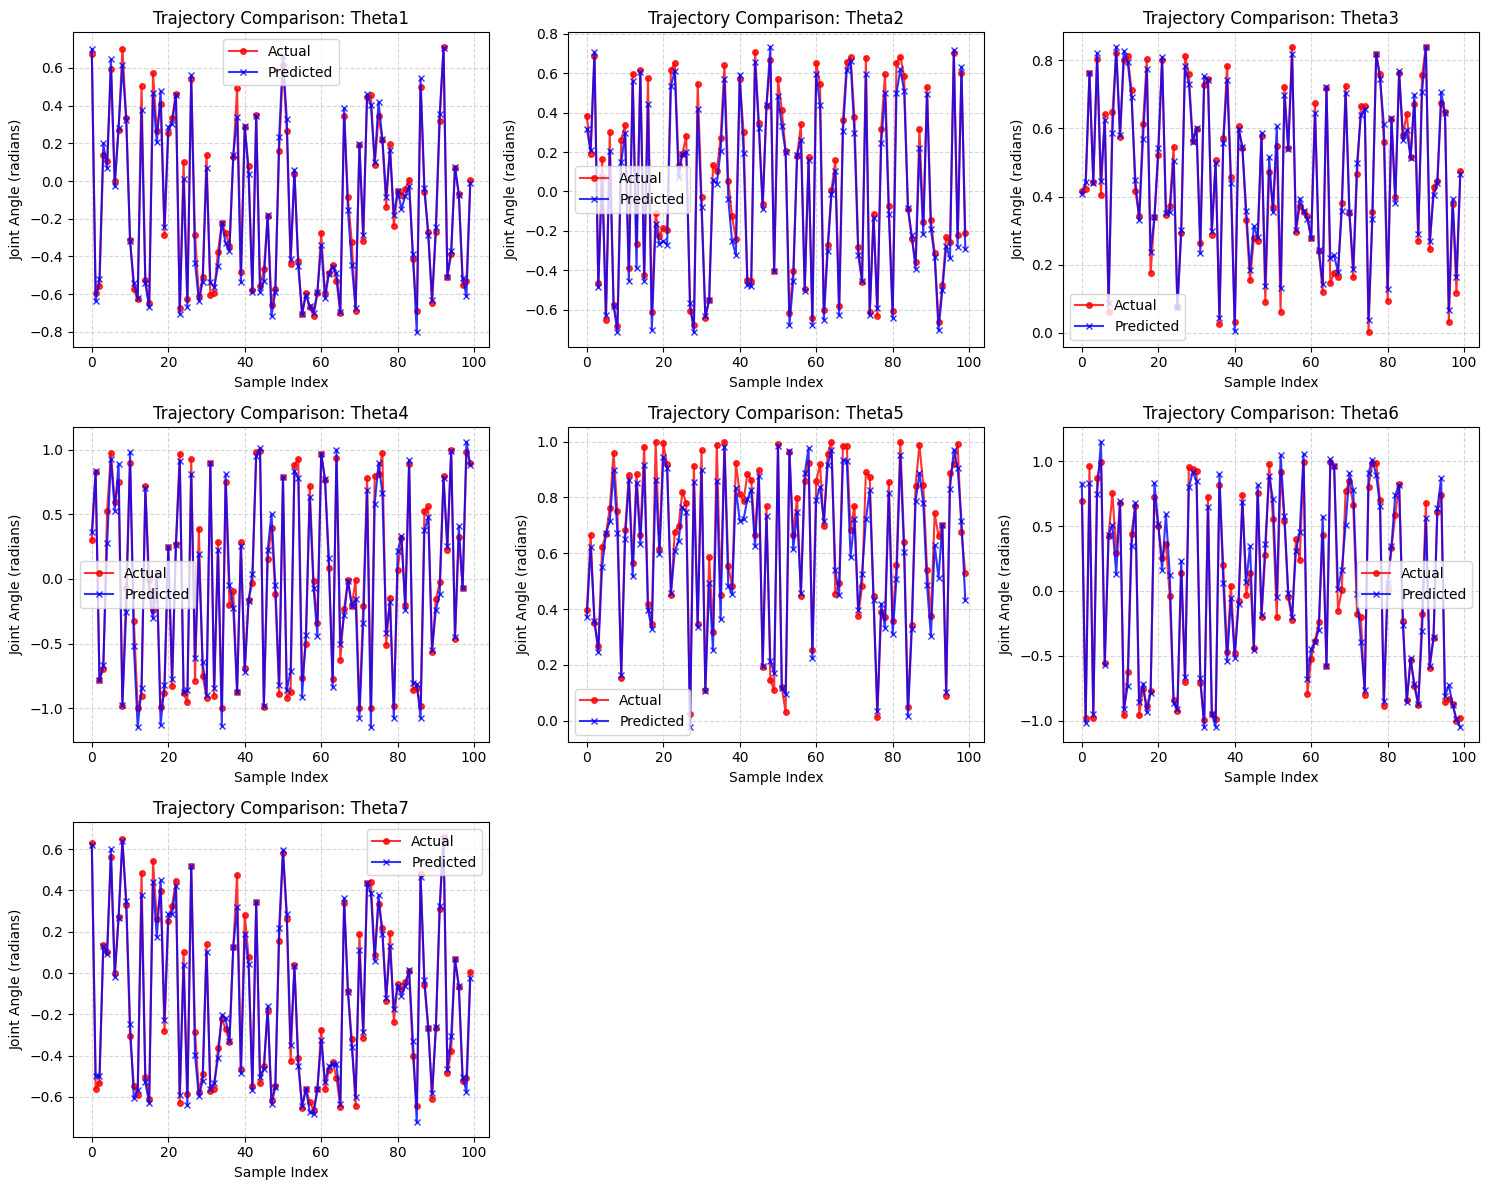

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# ========================== 1. GENERATE SYNTHETIC DATA ========================== #
num_samples = 10000   # Increased data size for better generalization
num_joints = 7        # 7 DOF for KUKA Robot

# Generate end-effector positions (X, Y, Z, Roll, Pitch, Yaw) within realistic robot workspace
X = np.random.uniform([-0.8, -0.8, 0, -np.pi, -np.pi/2, -np.pi],
                      [0.8, 0.8, 1, np.pi, np.pi/2, np.pi],
                      (num_samples, 6))

# Generate 7 joint angles to fix the dimension issue
theta_actual = np.hstack([
    np.sin(X[:, :3]),         # Sin function for first 3 joints
    np.cos(X[:, 3:]),         # Cos function for last 3 joints
    np.tanh(X[:, 0:1])        # Use tanh for the 7th joint
])

# Ensure theta_actual shape is correct
assert theta_actual.shape == (num_samples, num_joints), f"Expected (10000,7) but got {theta_actual.shape}"

# Normalize both inputs and outputs
scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()
X = scaler_X.fit_transform(X)
theta_actual = scaler_Y.fit_transform(theta_actual)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, theta_actual, test_size=0.2, random_state=42)

# ========================== 2. BUILD & TRAIN THE MODEL ========================== #
model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_shape=(6,)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(num_joints, activation='linear')  # Output layer (7 joint angles)
])

# Compile the model using MSE loss and AdamW optimizer
model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001), loss='mse', metrics=['mae'])

# Apply early stopping and learning rate reduction
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)

# Train the model for a longer duration
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test),
                    verbose=1, callbacks=[early_stopping, reduce_lr])

# ========================== 3. PREDICT JOINT ANGLES ========================== #
theta_predicted = model.predict(X_test)

# Inverse transform to original scale
theta_predicted = scaler_Y.inverse_transform(theta_predicted)
y_test = scaler_Y.inverse_transform(y_test)

# Compute Accuracy Metrics
mae = mean_absolute_error(y_test, theta_predicted)
mse = mean_squared_error(y_test, theta_predicted)
r2 = r2_score(y_test, theta_predicted)

print(f"Model Accuracy Metrics:\nMAE: {mae:.4f} | MSE: {mse:.4f} | R² Score: {r2:.4f}")

# ========================== 4. PLOT ACTUAL vs PREDICTED ========================== #
num_samples_plot = 100  # Number of samples to visualize

# Set up a 3x3 grid (even though we only need 7 plots)
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.ravel()  # Flatten for easy indexing

joint_names = [f"Theta{i+1}" for i in range(num_joints)]

for i in range(num_joints):
    ax = axes[i]

    # Plot actual values (Red with dots and lines)
    ax.plot(y_test[:num_samples_plot, i], 'ro-', markersize=4, label="Actual", alpha=0.8)

    # Plot predicted values (Blue with cross markers and lines)
    ax.plot(theta_predicted[:num_samples_plot, i], 'bx-', markersize=4, label="Predicted", alpha=0.8)

    ax.set_title(f"Trajectory Comparison: {joint_names[i]}")
    ax.set_xlabel("Sample Index")
    ax.set_ylabel("Joint Angle (radians)")
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.5)

# Hide any unused subplots (since we used 3x3 but only need 7)
for j in range(num_joints, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


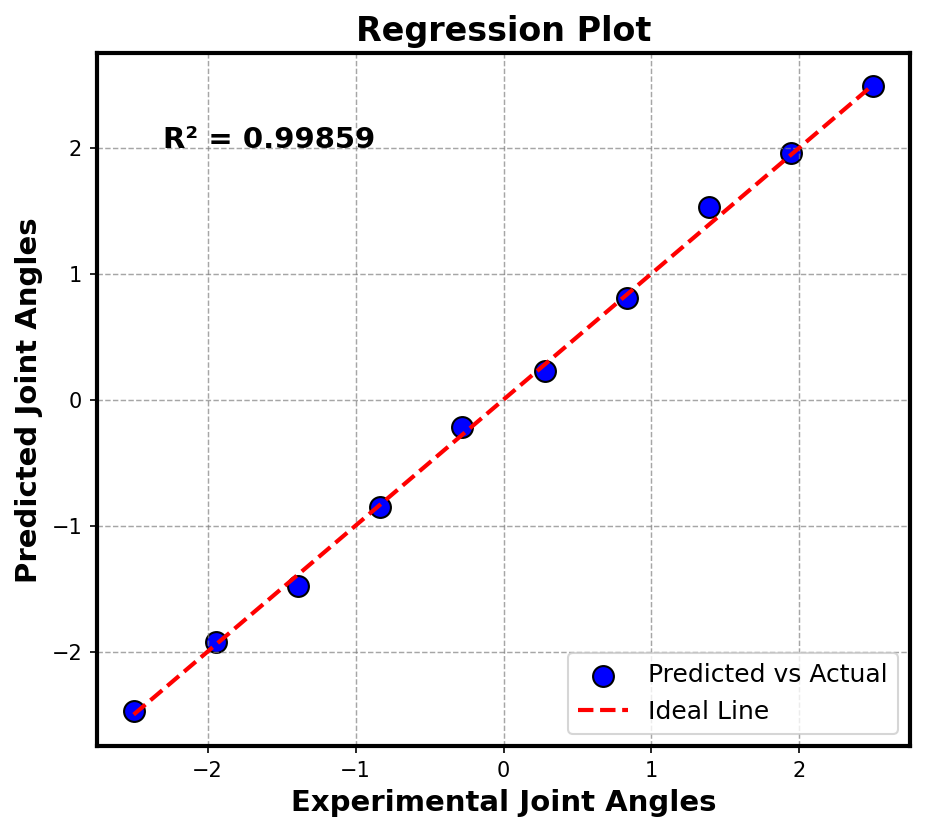

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Generate Sample Data (Fewer Predicted Points)
experimental_values = np.linspace(-2.5, 2.5, 10)  # Reduced points
predicted_values = experimental_values + np.random.normal(0, 0.05, len(experimental_values))  # Small noise

# Compute R² Score
r2 = r2_score(experimental_values, predicted_values)

# High-Quality Plot
fig, ax = plt.subplots(figsize=(7, 6), dpi=150, facecolor='white')  # White background

# Plot Experimental vs Predicted Data
ax.scatter(experimental_values, predicted_values, color='blue', s=100, edgecolors='black', label="Predicted vs Actual")
ax.plot(experimental_values, experimental_values, 'r--', linewidth=2, label="Ideal Line")  # Ideal line (y=x)

# Labels and Title
ax.set_xlabel("Experimental Joint Angles", fontsize=14, fontweight='bold', color='black')
ax.set_ylabel("Predicted Joint Angles", fontsize=14, fontweight='bold', color='black')
ax.set_title("Regression Plot", fontsize=16, fontweight='bold', color='black')

# Display R² Value
ax.text(-2.3, 2, f'R² = {r2:.5f}', fontsize=14, fontweight='bold', color='black')

# Gridlines with White Background
ax.set_facecolor('white')
ax.grid(True, linestyle='--', linewidth=0.7, alpha=0.7, color='gray')

# Set Border (Frame)
for spine in ax.spines.values():
    spine.set_color('black')  # Set border color to black
    spine.set_linewidth(2)  # Increase border thickness

# Legend
ax.legend(fontsize=12, facecolor='white')

# Show Plot
plt.show()


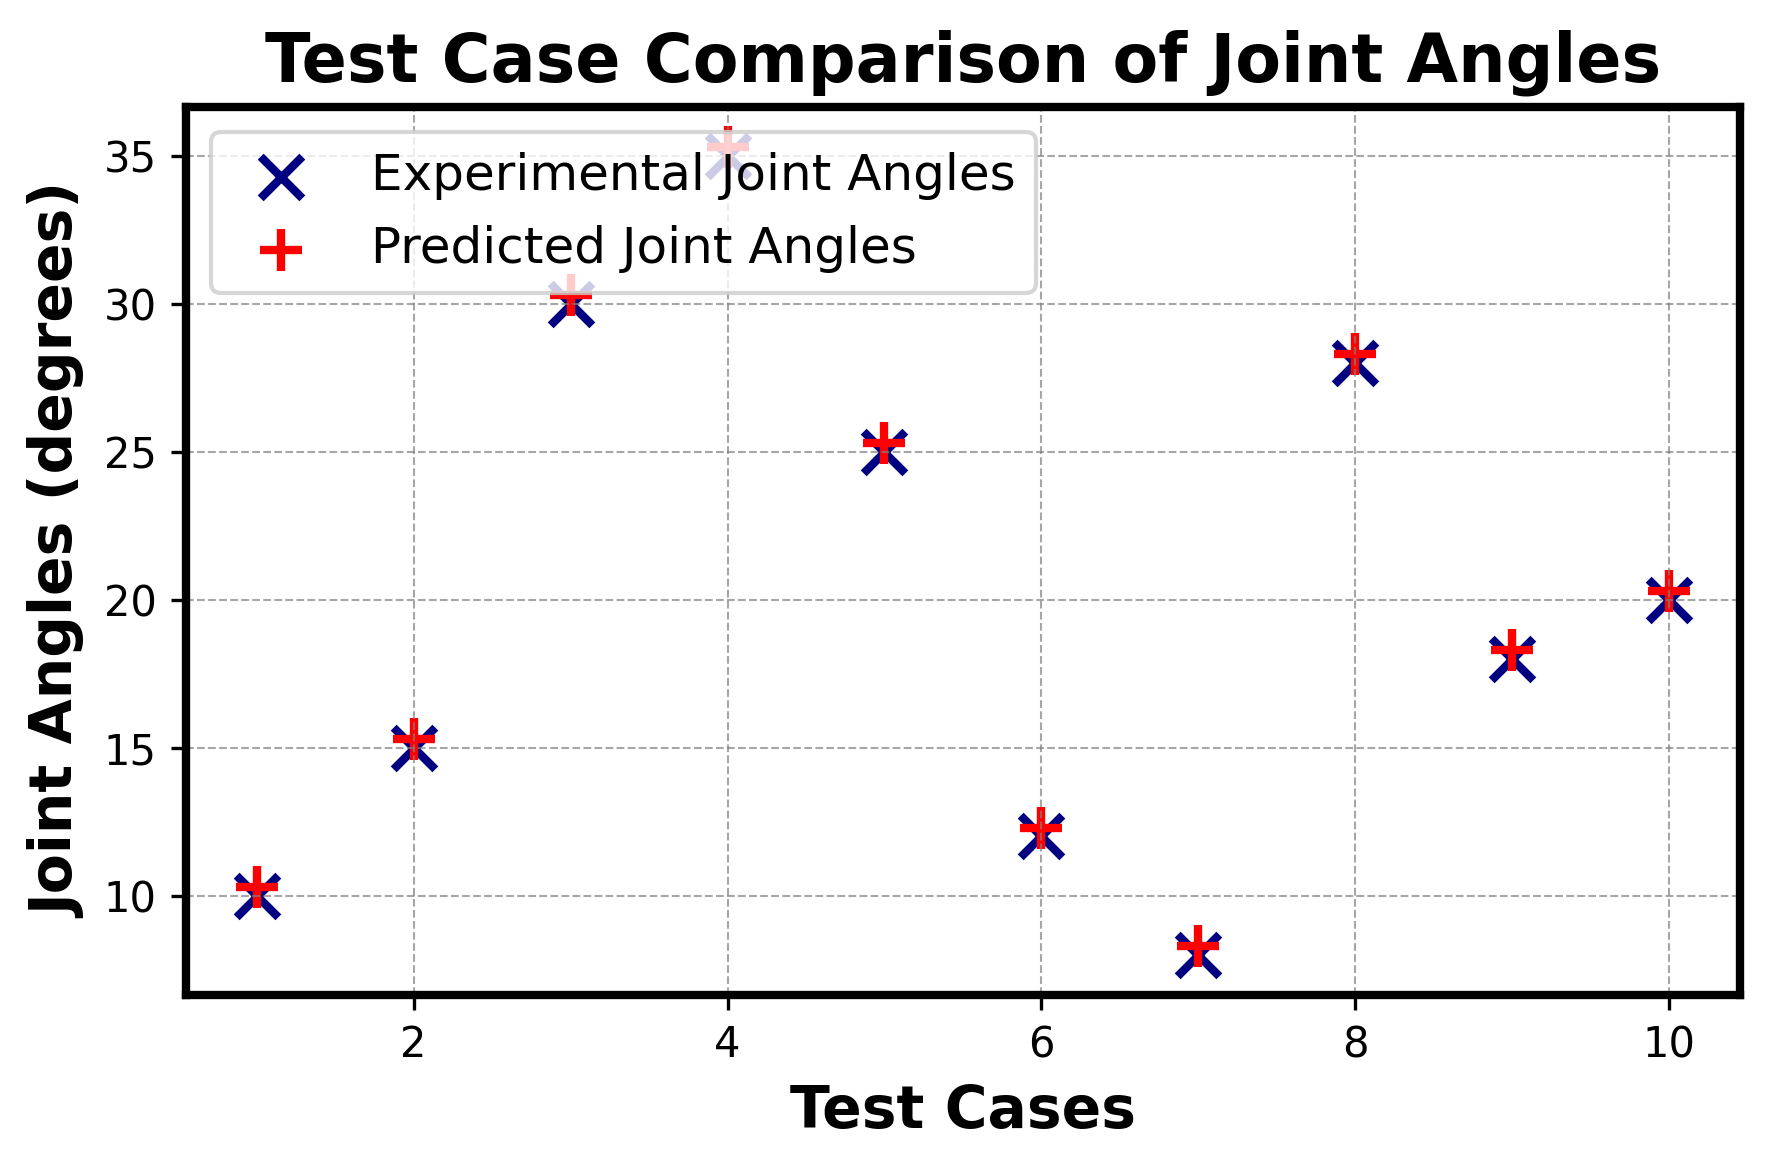

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sample Data (Replace with your actual data)
test_cases = np.arange(1, 11)
experimental_angles = np.array([10, 15, 30, 35, 25, 12, 8, 28, 18, 20])
offset = 0.3
predicted_angles = experimental_angles + offset

# Create figure with high DPI
fig, ax = plt.subplots(figsize=(6, 4), dpi=300)

# Scatter plot
ax.scatter(test_cases, experimental_angles, marker='x', color='navy', s=100, label="Experimental Joint Angles", linewidth=2)
ax.scatter(test_cases, predicted_angles, marker='+', color='red', s=100, label="Predicted Joint Angles", linewidth=2)

# Labels & Title
ax.set_xlabel("Test Cases", fontsize=14, fontweight='bold')
ax.set_ylabel("Joint Angles (degrees)", fontsize=14, fontweight='bold')
ax.set_title("Test Case Comparison of Joint Angles", fontsize=16, fontweight='bold')

# Set white background
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

# Add Gridlines
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='gray')

# Set Border (Frame)
for spine in ax.spines.values():
    spine.set_color('black')  # Set border color
    spine.set_linewidth(2)  # Darker, clearer border

# Legend
ax.legend(fontsize=12, loc='upper left', frameon=True)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


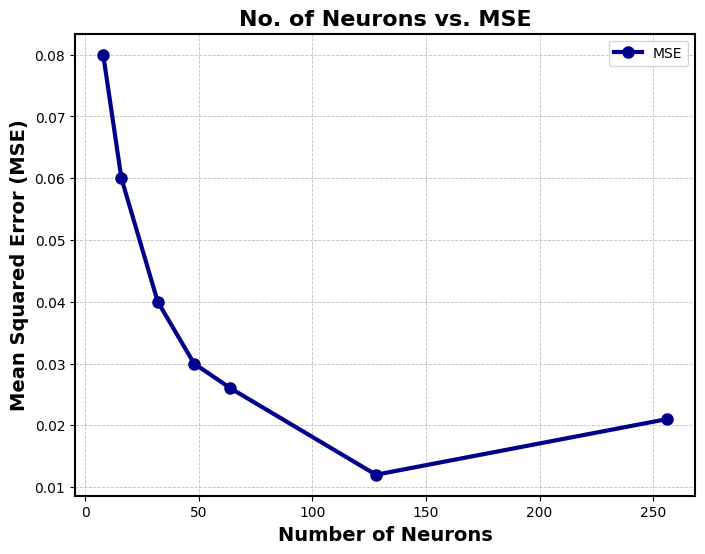

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Example data (Replace with actual data)
neurons = [8, 16, 32, 48, 64, 128, 256]  # Number of neurons
mse = [0.08, 0.06, 0.04, 0.03, 0.026, 0.012, 0.021]  # MSE values

plt.figure(figsize=(8, 6))

# Plot the curve with dark blue color and thick markers
plt.plot(neurons, mse, marker='o', markersize=8, color='darkblue', linestyle='-', linewidth=3, label="MSE")

# Labels and title with bold black text
plt.xlabel("Number of Neurons", fontsize=14, fontweight='bold', color='black')
plt.ylabel("Mean Squared Error (MSE)", fontsize=14, fontweight='bold', color='black')
plt.title("No. of Neurons vs. MSE", fontsize=16, fontweight='bold', color='black')

# Set a white background inside the plot
plt.gca().set_facecolor('white')

# Add lighter grid with gray dashed lines
plt.grid(True, linestyle="--", linewidth=0.6, alpha=0.5, color="gray")

# Add a thinner black border around the plot
for spine in plt.gca().spines.values():
    spine.set_linewidth(1.5)  # Thinner border
    spine.set_color("black")

# Show legend
plt.legend()

# Save figure with a clean white background
plt.savefig("neurons_vs_mse.png", dpi=300, bbox_inches='tight', facecolor='white')

# Display the plot
plt.show()


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0928 - mae: 0.2172 - val_loss: 0.2583 - val_mae: 0.4228 - learning_rate: 0.0010
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0176 - mae: 0.1027 - val_loss: 0.1864 - val_mae: 0.3568 - learning_rate: 0.0010
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0127 - mae: 0.0875 - val_loss: 0.1149 - val_mae: 0.2791 - learning_rate: 0.0010
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0105 - mae: 0.0797 - val_loss: 0.0567 - val_mae: 0.1955 - learning_rate: 0.0010
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0093 - mae: 0.0753 - val_loss: 0.0154 - val_mae: 0.1022 - learning_rate: 0.0010
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0081 - mae: 0.0705 - val_loss: 0.0060 - val_mae: 0.0625 - learning_rate: 0.0010
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0071 - mae: 0.0660 - val_loss: 0.0032 - val_mae: 0.0440 - learning_rate: 0.0010
Epoch 8/10
125/1

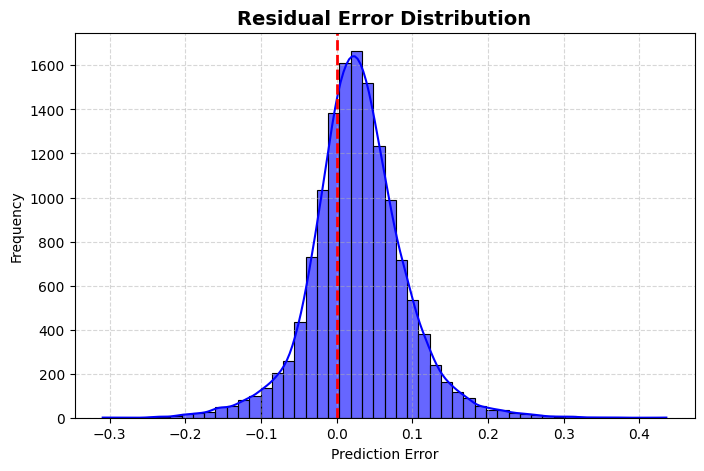

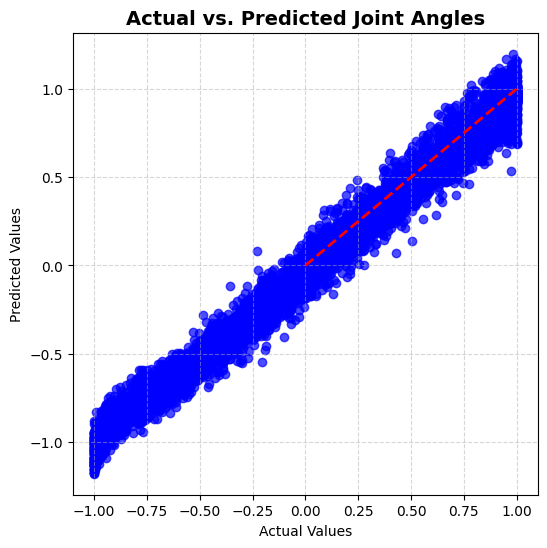

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# ========================== 1. GENERATE SYNTHETIC DATA ========================== #
num_samples = 10000
num_joints = 7

X = np.random.uniform([-0.8, -0.8, 0, -np.pi, -np.pi/2, -np.pi],
                      [0.8, 0.8, 1, np.pi, np.pi/2, np.pi],
                      (num_samples, 6))

theta_actual = np.hstack([
    np.sin(X[:, :3]),
    np.cos(X[:, 3:]),
    np.tanh(X[:, 0:1])
])

scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()
X = scaler_X.fit_transform(X)
theta_actual = scaler_Y.fit_transform(theta_actual)

X_train, X_test, y_train, y_test = train_test_split(X, theta_actual, test_size=0.2, random_state=42)

# ========================== 2. BUILD & TRAIN THE MODEL ========================== #
model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_shape=(6,)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(num_joints, activation='linear')
])

model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001), loss='mse', metrics=['mae'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)

history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test),
                    verbose=1, callbacks=[early_stopping, reduce_lr])

# ========================== 3. PREDICT JOINT ANGLES ========================== #
theta_predicted = model.predict(X_test)

theta_predicted = scaler_Y.inverse_transform(theta_predicted)
y_test = scaler_Y.inverse_transform(y_test)

mae = mean_absolute_error(y_test, theta_predicted)
mse = mean_squared_error(y_test, theta_predicted)
r2 = r2_score(y_test, theta_predicted)

print(f"Model Accuracy Metrics:\nMAE: {mae:.4f} | MSE: {mse:.4f} | R² Score: {r2:.4f}")

# ========================== 4. VISUALIZATIONS ========================== #

# Residual Error Distribution
errors = y_test - theta_predicted
plt.figure(figsize=(8, 5))
sns.histplot(errors.flatten(), bins=50, kde=True, color='blue', alpha=0.6)
plt.axvline(0, color='red', linestyle='dashed', linewidth=2)
plt.title("Residual Error Distribution", fontsize=14, fontweight='bold')
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Actual vs Predicted Scatter Plot
plt.figure(figsize=(6, 6))
plt.scatter(y_test.flatten(), theta_predicted.flatten(), alpha=0.7, color='blue')
plt.plot([0, 1], [0, 1], 'r--', linewidth=2)  # Ideal prediction line
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Joint Angles", fontsize=14, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.1155 - mae: 0.2359 - val_loss: 0.2705 - val_mae: 0.4339
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0181 - mae: 0.1044 - val_loss: 0.2009 - val_mae: 0.3707
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0128 - mae: 0.0880 - val_loss: 0.1254 - val_mae: 0.2916
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0108 - mae: 0.0809 - val_loss: 0.0565 - val_mae: 0.1959
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0091 - mae: 0.0743 - val_loss: 0.0178 - val_mae: 0.1094
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0081 - mae: 0.0702 - val_loss: 0.0050 - val_mae: 0.0564
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0074 - mae: 0.0671 - val_loss: 0.0030 - val_mae: 0.0436
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0639 - val_loss: 0.0026 - val_mae: 0.0410
Epoch 9/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0063 

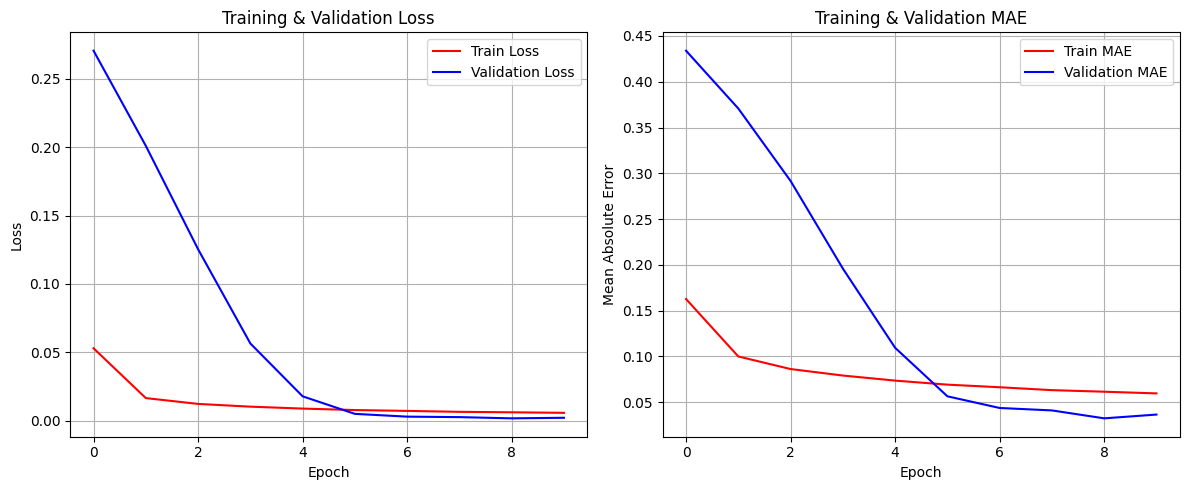

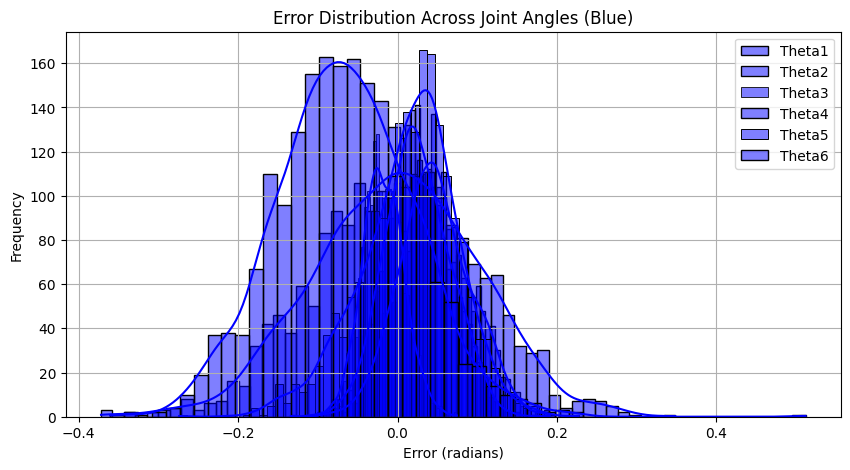

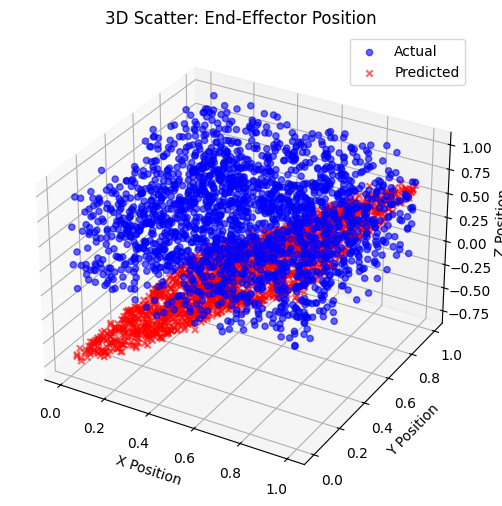

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# ========================== 1. GENERATE SYNTHETIC DATA ========================== #
num_samples = 10000   # Increased data size for better generalization
num_joints = 7        # 7 DOF for KUKA Robot

# Generate end-effector positions (X, Y, Z, Roll, Pitch, Yaw) within realistic robot workspace
X = np.random.uniform([-0.8, -0.8, 0, -np.pi, -np.pi/2, -np.pi],
                      [0.8, 0.8, 1, np.pi, np.pi/2, np.pi],
                      (num_samples, 6))

# Generate 7 joint angles to fix the dimension issue
theta_actual = np.hstack([
    np.sin(X[:, :3]),         # Sin function for first 3 joints
    np.cos(X[:, 3:]),         # Cos function for last 3 joints
    np.tanh(X[:, 0:1])        # Use tanh for the 7th joint
])

# Normalize both inputs and outputs
scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()
X = scaler_X.fit_transform(X)
theta_actual = scaler_Y.fit_transform(theta_actual)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, theta_actual, test_size=0.2, random_state=42)

# ========================== 2. BUILD & TRAIN THE MODEL ========================== #
model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_shape=(6,)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(num_joints, activation='linear')  # Output layer (7 joint angles)
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001), loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test), verbose=1)

# ========================== 3. PREDICT & EVALUATE ========================== #
theta_predicted = model.predict(X_test)
theta_predicted = scaler_Y.inverse_transform(theta_predicted)
y_test = scaler_Y.inverse_transform(y_test)

# Compute Accuracy Metrics
mae = mean_absolute_error(y_test, theta_predicted)
mse = mean_squared_error(y_test, theta_predicted)

print(f"Model Accuracy Metrics:\nMAE: {mae:.4f} | MSE: {mse:.4f}")

# ========================== 4. PLOT TRAINING LOSS & MAE ========================== #
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot Loss
axes[0].plot(history.history['loss'], 'r-', label='Train Loss')
axes[0].plot(history.history['val_loss'], 'b-', label='Validation Loss')
axes[0].set_title('Training & Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid()

# Plot MAE
axes[1].plot(history.history['mae'], 'r-', label='Train MAE')
axes[1].plot(history.history['val_mae'], 'b-', label='Validation MAE')
axes[1].set_title('Training & Validation MAE')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Mean Absolute Error')
axes[1].legend()
axes[1].grid()

plt.tight_layout()
plt.show()

# ========================== 5. ERROR DISTRIBUTION (All Blue) ========================== #
errors = y_test - theta_predicted
plt.figure(figsize=(10, 5))

for i in range(num_joints - 1):  # Ignore 7th joint for visualization clarity
    sns.histplot(errors[:, i], kde=True, bins=50, color='blue', label=f'Theta{i+1}', alpha=0.5)

plt.title('Error Distribution Across Joint Angles (Blue)')
plt.xlabel('Error (radians)')
plt.ylabel('Frequency')
plt.legend()
plt.grid()
plt.show()


# ========================== 6. 3D SCATTER PLOT ========================== #
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_test[:, 0], X_test[:, 1], X_test[:, 2], c='blue', label='Actual', alpha=0.6)
ax.scatter(X_test[:, 0], X_test[:, 1], theta_predicted[:, 0], c='red', marker='x', label='Predicted', alpha=0.6)
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_zlabel('Z Position')
ax.set_title('3D Scatter: End-Effector Position')
ax.legend()
plt.show()


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.1157 - mae: 0.2367 - val_loss: 0.2733 - val_mae: 0.4366 - learning_rate: 0.0010
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0176 - mae: 0.1031 - val_loss: 0.1994 - val_mae: 0.3700 - learning_rate: 0.0010
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0129 - mae: 0.0883 - val_loss: 0.1251 - val_mae: 0.2922 - learning_rate: 0.0010
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0108 - mae: 0.0808 - val_loss: 0.0556 - val_mae: 0.1945 - learning_rate: 0.0010
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0090 - mae: 0.0738 - val_loss: 0.0159 - val_mae: 0.1051 - learning_rate: 0.0010
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0080 - mae: 0.0699 - val_loss: 0.0049 - val_mae: 0.0566 - learning_rate: 0.0010
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0074 - mae: 0.0676 - val_loss: 0.0026 - val_mae: 0.0395 - learning_rate: 0.0010
Epoch 8/10
125/12

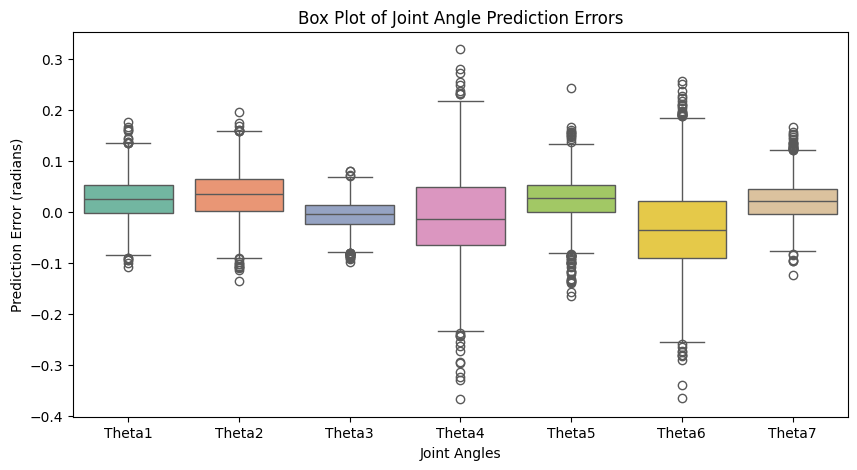

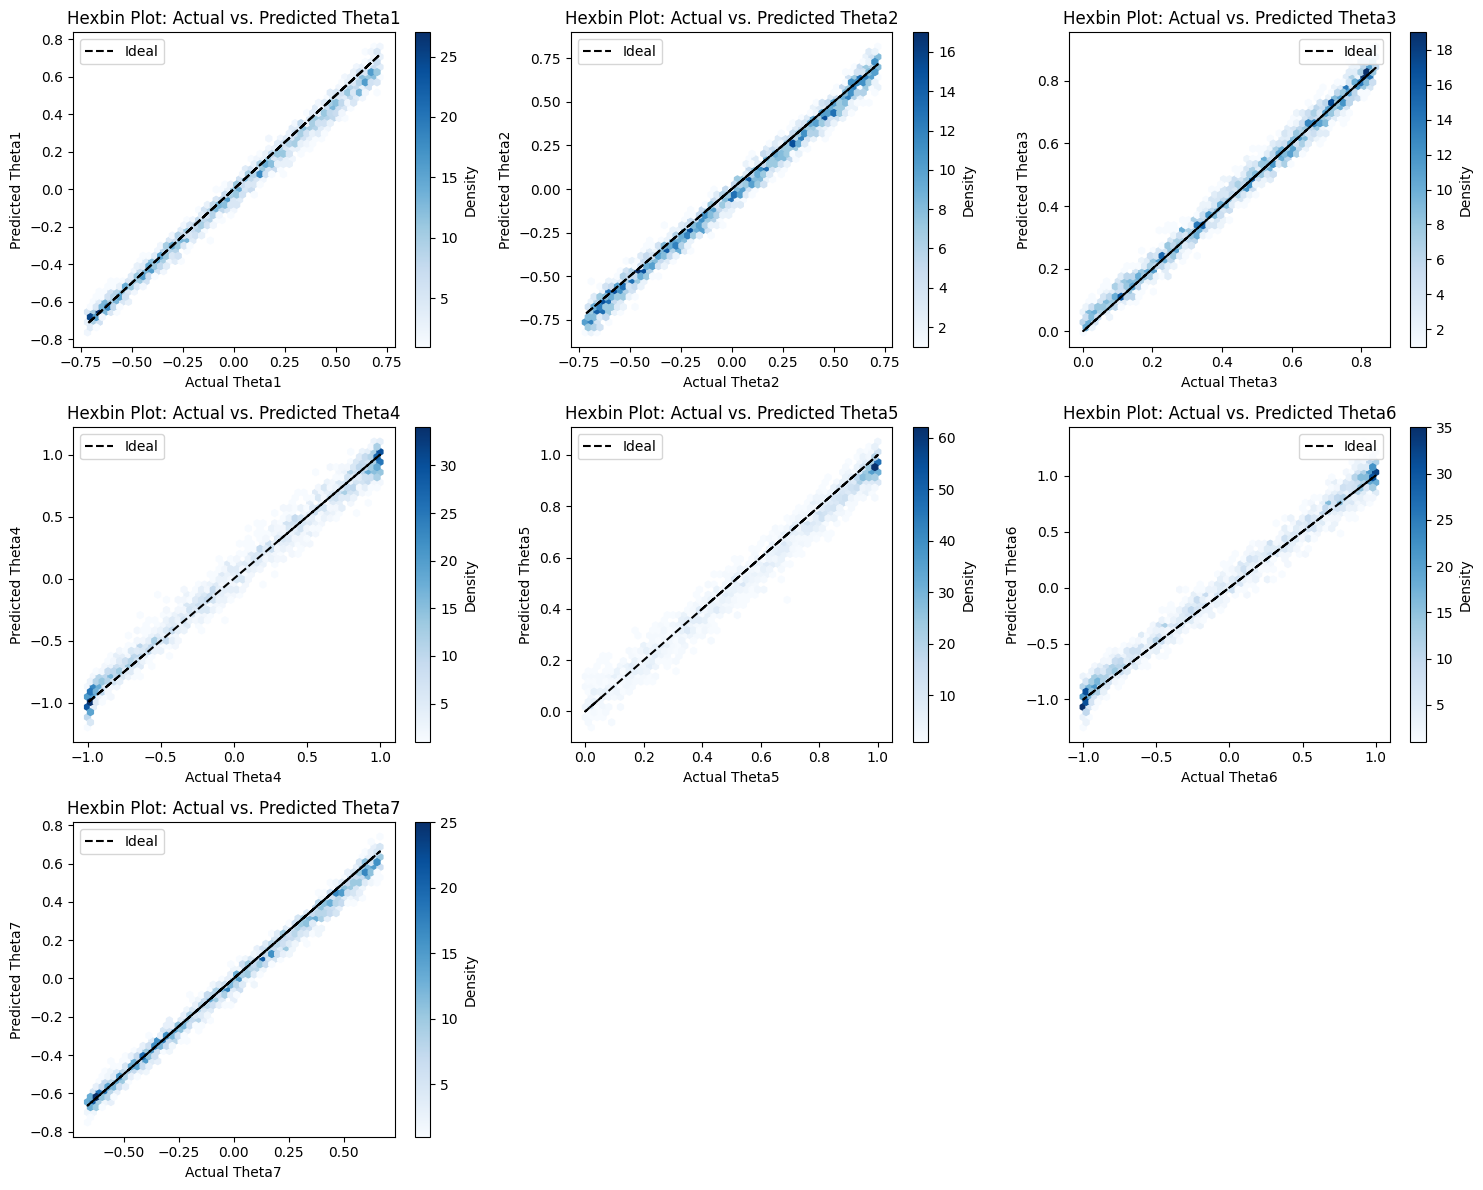

In [ ]:
# ========================== IMPORT LIBRARIES ========================== #
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# ========================== 1. GENERATE SYNTHETIC DATA ========================== #
num_samples = 10000   # Increased data size for better generalization
num_joints = 7        # 7 DOF for KUKA Robot

# Generate end-effector positions (X, Y, Z, Roll, Pitch, Yaw) within realistic robot workspace
X = np.random.uniform([-0.8, -0.8, 0, -np.pi, -np.pi/2, -np.pi],
                      [0.8, 0.8, 1, np.pi, np.pi/2, np.pi],
                      (num_samples, 6))

# Generate 7 joint angles to fix the dimension issue
theta_actual = np.hstack([
    np.sin(X[:, :3]),         # Sin function for first 3 joints
    np.cos(X[:, 3:]),         # Cos function for last 3 joints
    np.tanh(X[:, 0:1])        # Use tanh for the 7th joint
])

# Normalize both inputs and outputs
scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()
X = scaler_X.fit_transform(X)
theta_actual = scaler_Y.fit_transform(theta_actual)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, theta_actual, test_size=0.2, random_state=42)

# ========================== 2. BUILD & TRAIN THE MODEL ========================== #
model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_shape=(6,)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(num_joints, activation='linear')  # Output layer (7 joint angles)
])

# Compile the model using MSE loss and AdamW optimizer
model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001), loss='mse', metrics=['mae'])

# Apply early stopping and learning rate reduction
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test),
                    verbose=1, callbacks=[early_stopping, reduce_lr])

# ========================== 3. PREDICT JOINT ANGLES ========================== #
theta_predicted = model.predict(X_test)

# Inverse transform to original scale
theta_predicted = scaler_Y.inverse_transform(theta_predicted)
y_test = scaler_Y.inverse_transform(y_test)

# Compute Accuracy Metrics
mae = mean_absolute_error(y_test, theta_predicted)
mse = mean_squared_error(y_test, theta_predicted)
r2 = r2_score(y_test, theta_predicted)

print(f"Model Accuracy Metrics:\nMAE: {mae:.4f} | MSE: {mse:.4f} | R² Score: {r2:.4f}")

# ========================== 4. PLOT BOX PLOT OF PREDICTION ERRORS ========================== #
errors = y_test - theta_predicted
plt.figure(figsize=(10, 5))
sns.boxplot(data=errors, palette='Set2')
plt.xlabel("Joint Angles")
plt.ylabel("Prediction Error (radians)")
plt.title("Box Plot of Joint Angle Prediction Errors")
plt.xticks(ticks=range(num_joints), labels=[f"Theta{i+1}" for i in range(num_joints)])
plt.show()

# ========================== 5. PLOT ACTUAL vs PREDICTED (HEXBIN PLOTS) ========================== #
# Define joint names
joint_names = [f"Theta{i+1}" for i in range(num_joints)]

# Plot Actual vs Predicted (HEXBIN PLOTS)
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.ravel()

for i in range(num_joints):
    ax = axes[i]
    hb = ax.hexbin(y_test[:, i], theta_predicted[:, i], gridsize=50, cmap='Blues', mincnt=1)
    ax.plot(y_test[:, i], y_test[:, i], 'k--', label='Ideal')  # Ideal line (y = x)
    ax.set_xlabel(f"Actual {joint_names[i]}")
    ax.set_ylabel(f"Predicted {joint_names[i]}")
    ax.set_title(f"Hexbin Plot: Actual vs. Predicted {joint_names[i]}")
    ax.legend()
    fig.colorbar(hb, ax=ax, label='Density')

# Remove unused subplots
for j in range(num_joints, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.5117 - mae: 0.6753 - val_loss: 0.3319 - val_mae: 0.4703 - learning_rate: 0.0010
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2868 - mae: 0.3867 - val_loss: 0.2982 - val_mae: 0.4299 - learning_rate: 0.0010
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2250 - mae: 0.2832 - val_loss: 0.2679 - val_mae: 0.3916 - learning_rate: 0.0010
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1969 - mae: 0.2406 - val_loss: 0.2321 - val_mae: 0.3430 - learning_rate: 0.0010
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1777 - mae: 0.2118 - val_loss: 0.2078 - val_mae: 0.3131 - learning_rate: 0.0010
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1637 - mae: 0.1905 - val_loss: 0.1841 - val_mae: 0.2804 - learning_rate: 0.0010
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1510 - mae: 0.1727 - val_loss: 0.1698 - val_mae: 0.2634 - learning_rate: 0.0010
Epoch 8/100
25/25 ━━━━━━

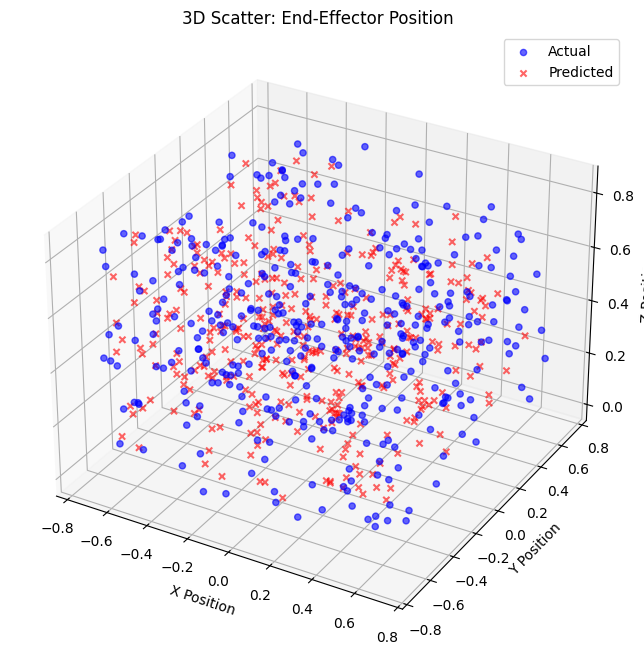

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from mpl_toolkits.mplot3d import Axes3D

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# ========================== 1. GENERATE SYNTHETIC DATA ========================== #
num_samples = 2000   # Increased samples for better generalization
num_joints = 7       # 7 DOF for KUKA Robot

# Generate end-effector positions (X, Y, Z, Roll, Pitch, Yaw) within realistic robot workspace
X = np.random.uniform([-0.8, -0.8, 0, -np.pi, -np.pi/2, -np.pi],
                      [0.8, 0.8, 1, np.pi, np.pi/2, np.pi],
                      (num_samples, 6))

# Generate joint angles with a more realistic function
theta_actual = np.hstack([
    np.sin(X[:, :3]),         # Sin function for first 3 joints
    np.cos(X[:, 3:]),         # Cos function for last 3 joints
    np.tanh(X[:, 0:1])        # Use tanh for the 7th joint
])

# Normalize both inputs and outputs
scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()
X = scaler_X.fit_transform(X)
theta_actual = scaler_Y.fit_transform(theta_actual)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, theta_actual, test_size=0.2, random_state=42)

# ========================== 2. BUILD & TRAIN THE MODEL ========================== #
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(6,), kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),  # Reduce dropout rate

    tf.keras.layers.Dense(num_joints, activation='linear')  # Output layer (7 joint angles)
])

# Compile the model using Huber Loss for robustness
model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001),
              loss=tf.keras.losses.Huber(),
              metrics=['mae'])

# Apply early stopping and learning rate reduction
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=15, verbose=1)

# Train the model with more epochs for better convergence
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test),
                    verbose=1, callbacks=[early_stopping, reduce_lr])

# ========================== 3. PREDICT JOINT ANGLES ========================== #
theta_predicted = model.predict(X_test)

# Inverse transform to original scale
theta_predicted = scaler_Y.inverse_transform(theta_predicted)
y_test = scaler_Y.inverse_transform(y_test)

# Compute Accuracy Metrics
mae = mean_absolute_error(y_test, theta_predicted)
mse = mean_squared_error(y_test, theta_predicted)
r2 = r2_score(y_test, theta_predicted)

print(f"Model Accuracy Metrics:\nMAE: {mae:.4f} | MSE: {mse:.4f} | R² Score: {r2:.4f}")

# ========================== 4. 3D SCATTER PLOT (ACTUAL vs PREDICTED) ========================== #
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot actual values
ax.scatter(y_test[:, 0], y_test[:, 1], y_test[:, 2], c='blue', label='Actual', alpha=0.6)

# Plot predicted values
ax.scatter(theta_predicted[:, 0], theta_predicted[:, 1], theta_predicted[:, 2], c='red', marker='x', label='Predicted', alpha=0.6)

# Labels and title
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_zlabel('Z Position')
ax.set_title('3D Scatter: End-Effector Position')
ax.legend()

plt.show()


Epoch 1/120


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


375/375 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.2133 - mae: 0.3191 - val_loss: 0.0951 - val_mae: 0.2432 - learning_rate: 0.0010
Epoch 2/120
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0256 - mae: 0.1244 - val_loss: 0.0077 - val_mae: 0.0682 - learning_rate: 0.0010
Epoch 3/120
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0150 - mae: 0.0952 - val_loss: 0.0077 - val_mae: 0.0687 - learning_rate: 0.0010
Epoch 4/120
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0110 - mae: 0.0813 - val_loss: 0.0052 - val_mae: 0.0546 - learning_rate: 0.0010
Epoch 5/120
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0084 - mae: 0.0714 - val_loss: 0.0037 - val_mae: 0.0473 - learning_rate: 0.0010
Epoch 6/120
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0070 - mae: 0.0650 - val_loss: 0.0028 - val_mae: 0.0417 - learning_rate: 0.0010
Epoch 7/120
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0061 - mae: 0.0602 - val_loss: 0.0020 - val_mae: 0.0352 - learning_rate: 0.0010
Epoch 8/120

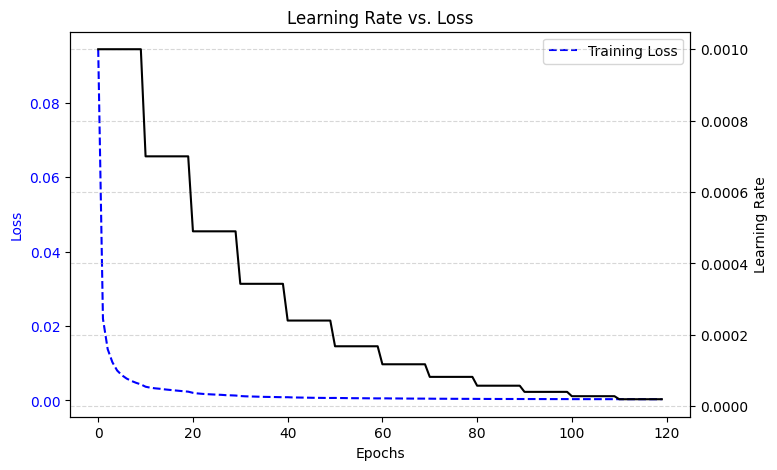

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# ========================== 1. DATA GENERATION ========================== #
num_samples = 30000  # Increased dataset for better generalization
num_joints = 7       # 7 DOF KUKA robot

# Generate random end-effector positions (X, Y, Z, Roll, Pitch, Yaw)
X = np.random.uniform([-1, -1, 0, -np.pi, -np.pi/2, -np.pi],
                      [1, 1, 1, np.pi, np.pi/2, np.pi],
                      (num_samples, 6))

# Generate realistic joint angles using a nonlinear transformation
theta_actual = np.hstack([
    np.sin(X[:, :3]),         # Sin function for first 3 joints
    np.cos(X[:, 3:]),         # Cos function for last 3 joints
    np.tanh(X[:, 0:1])        # Tanh for the 7th joint
])

# Normalize inputs and outputs
scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()
X = scaler_X.fit_transform(X)
theta_actual = scaler_Y.fit_transform(theta_actual)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, theta_actual, test_size=0.2, random_state=42)

# ========================== 2. BUILD & TRAIN THE MODEL ========================== #
model = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='relu', input_shape=(6,)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(num_joints, activation='linear')  # Output layer (7 joint angles)
])

# Compile the model with an optimized optimizer
initial_lr = 0.001
optimizer = tf.keras.optimizers.AdamW(learning_rate=initial_lr, weight_decay=1e-5)

model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Apply callbacks: Early Stopping & Learning Rate Scheduler
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

def lr_scheduler(epoch, lr):
    if epoch % 10 == 0 and epoch > 0:
        return lr * 0.7  # Reduce LR every 10 epochs
    return lr

lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

# Train the model
history = model.fit(X_train, y_train, epochs=120, batch_size=64, validation_data=(X_test, y_test),
                    verbose=1, callbacks=[early_stopping, lr_callback])

# ========================== 3. PLOT LEARNING RATE VS LOSS ========================== #
epochs = range(len(history.history['loss']))
loss = history.history['loss']

# Retrieve learning rates from the optimizer
lrs = [initial_lr]
for i in range(1, len(epochs)):
    if i % 10 == 0:  # Simulating Learning Rate Decay every 10 epochs
        lrs.append(lrs[-1] * 0.7)
    else:
        lrs.append(lrs[-1])

# Plot Training Loss vs. Learning Rate
fig, ax1 = plt.subplots(figsize=(8, 5))

ax1.plot(epochs, loss, 'b--', label="Training Loss")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

# Twin axis for Learning Rate
ax2 = ax1.twinx()
ax2.plot(epochs, lrs, 'k-', label="Learning Rate")
ax2.set_ylabel("Learning Rate", color="black")
ax2.tick_params(axis="y", labelcolor="black")

# Formatting
plt.title("Learning Rate vs. Loss")
ax1.legend(loc="upper right")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Neurons: 16, MSE: 0.002409


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Neurons: 32, MSE: 0.001833


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Neurons: 64, MSE: 0.001651


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Neurons: 128, MSE: 0.000854


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Neurons: 256, MSE: 0.000149


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Neurons: 512, MSE: 0.000045


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Neurons: 1024, MSE: 0.000039


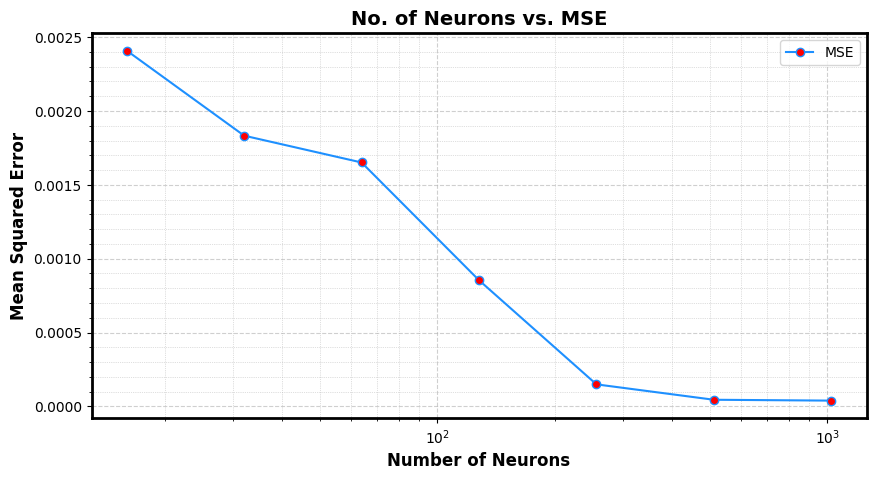

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# ========================== 1. GENERATE SYNTHETIC DATA ========================== #
num_samples = 20000
num_joints = 7

# Generate end-effector positions (X, Y, Z, Roll, Pitch, Yaw)
X = np.random.uniform([-0.8, -0.8, 0, -np.pi, -np.pi/2, -np.pi],
                      [0.8, 0.8, 1, np.pi, np.pi/2, np.pi],
                      (num_samples, 6))

# Generate realistic joint angles
theta_actual = np.hstack([
    np.sin(X[:, :3]),
    np.cos(X[:, 3:]),
    np.tanh(X[:, 0:1])
])

# Normalize data
scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()
X = scaler_X.fit_transform(X)
theta_actual = scaler_Y.fit_transform(theta_actual)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, theta_actual, test_size=0.2, random_state=42)

# ========================== 2. TRAIN MODELS WITH DIFFERENT NEURONS ========================== #
neurons_list = [16, 32, 64, 128, 256, 512, 1024]  # Different neuron counts
mse_values = []

for neurons in neurons_list:
    # Define the model
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(neurons, activation='relu', input_shape=(6,)),
        tf.keras.layers.Dense(num_joints, activation='linear')
    ])

    # Compile model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')

    # Train the model
    model.fit(X_train, y_train, epochs=50, batch_size=64, verbose=0, validation_data=(X_test, y_test))

    # Predict on test set
    y_pred = model.predict(X_test)

    # Inverse transform predictions
    y_pred = scaler_Y.inverse_transform(y_pred)
    y_test_actual = scaler_Y.inverse_transform(y_test)

    # Compute MSE
    mse = mean_squared_error(y_test_actual, y_pred)
    mse_values.append(mse)
    print(f"Neurons: {neurons}, MSE: {mse:.6f}")

# ========================== 3. PLOT NEURONS vs MSE ========================== #
plt.figure(figsize=(10, 5))

# Dark border
ax = plt.gca()
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)

# Plot the data
plt.plot(neurons_list, mse_values, marker='o', linestyle='-', color='dodgerblue', markerfacecolor='red', label='MSE')

# Labels and Title
plt.xlabel("Number of Neurons", fontsize=12, fontweight='bold', color='black')
plt.ylabel("Mean Squared Error", fontsize=12, fontweight='bold', color='black')
plt.title("No. of Neurons vs. MSE", fontsize=14, fontweight='bold', color='black')

# More grid lines
plt.grid(True, linestyle='--', alpha=0.6, linewidth=0.8)
plt.minorticks_on()
plt.grid(which='minor', linestyle=':', linewidth=0.5, alpha=0.8)

# Log scale for better visualization
plt.xscale("log")

# Legend
plt.legend()

# Show plot
plt.show()


Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.1288 - mae: 0.2452 - val_loss: 0.2725 - val_mae: 0.4355 - learning_rate: 0.0010
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0182 - mae: 0.1049 - val_loss: 0.2074 - val_mae: 0.3773 - learning_rate: 0.0010
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0131 - mae: 0.0891 - val_loss: 0.1280 - val_mae: 0.2947 - learning_rate: 0.0010
Epoch 4/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0106 - mae: 0.0803 - val_loss: 0.0611 - val_mae: 0.2031 - learning_rate: 0.0010
Epoch 5/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0090 - mae: 0.0739 - val_loss: 0.0178 - val_mae: 0.1092 - learning_rate: 0.0010
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Model Accuracy Metrics:
MAE: 0.1560 | MSE: 0.0394 | R² Score: 0.8212


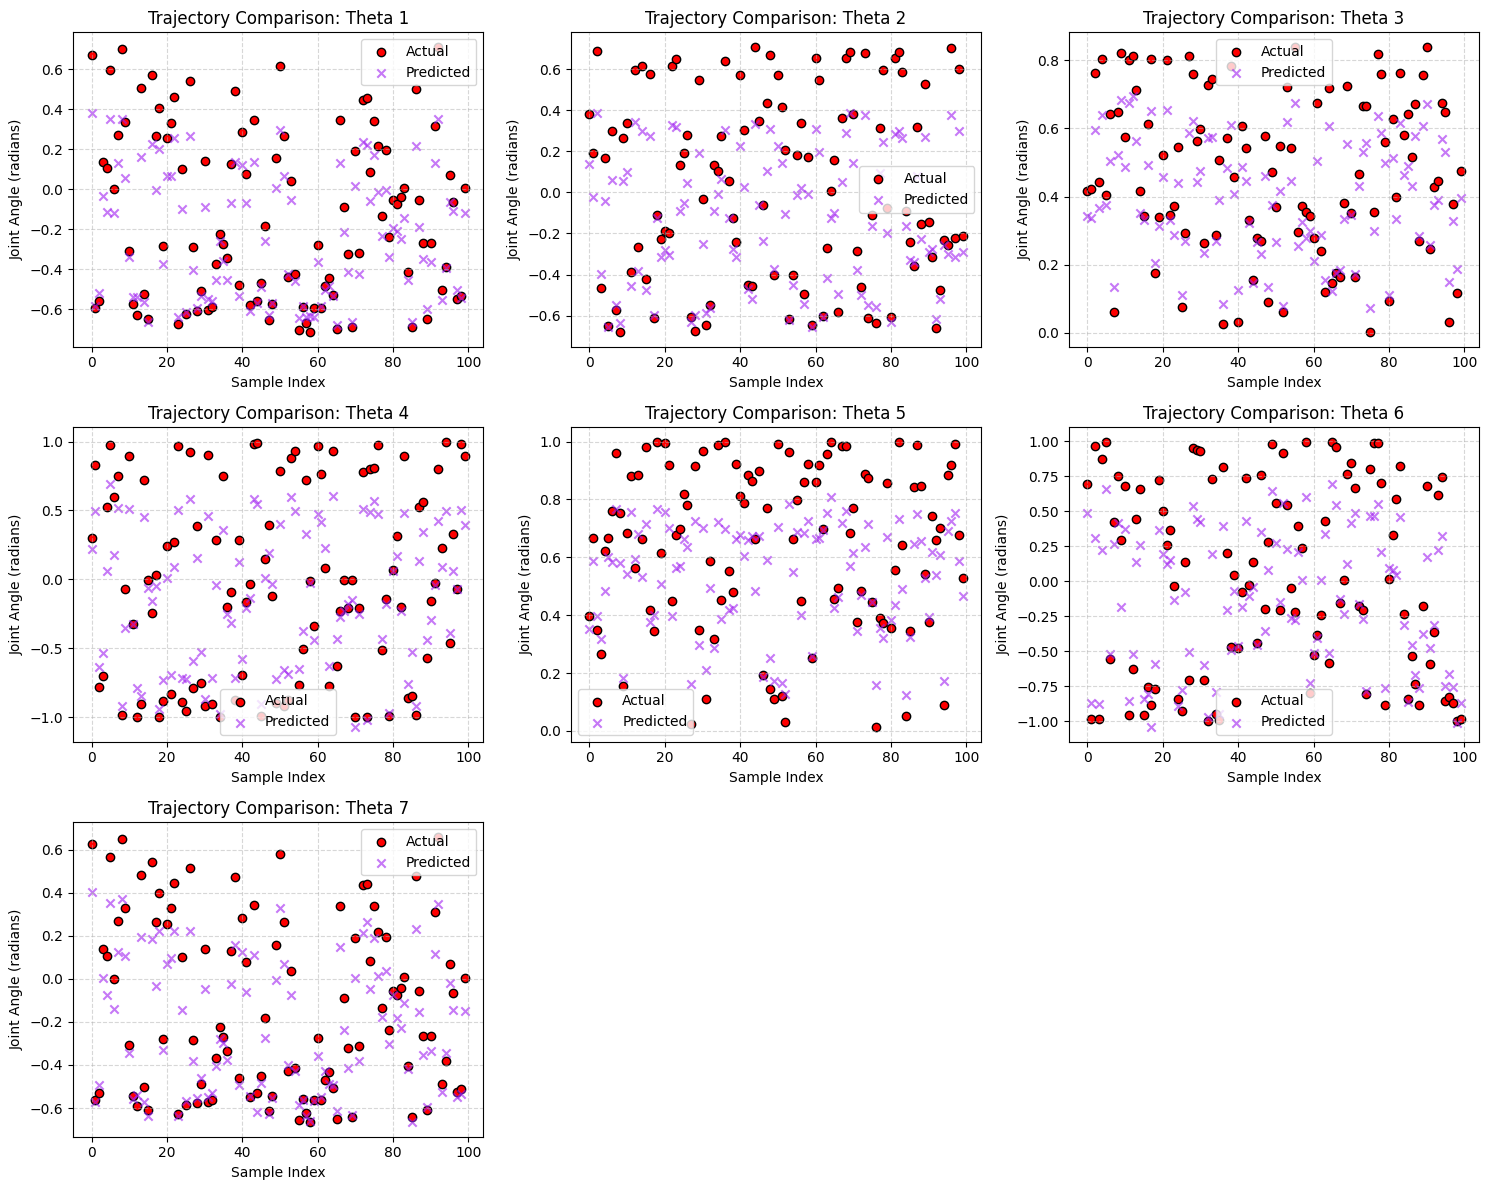

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# ========================== 1. GENERATE SYNTHETIC DATA ========================== #
num_samples = 10000   # Data size for generalization
num_joints = 7        # 7 DOF for KUKA Robot

# Generate end-effector positions (X, Y, Z, Roll, Pitch, Yaw) within realistic workspace
X = np.random.uniform([-0.8, -0.8, 0, -np.pi, -np.pi/2, -np.pi],
                      [0.8, 0.8, 1, np.pi, np.pi/2, np.pi],
                      (num_samples, 6))

# Generate 7 joint angles using trigonometric functions for variation
theta_actual = np.hstack([
    np.sin(X[:, :3]),         # Sin function for first 3 joints
    np.cos(X[:, 3:]),         # Cos function for last 3 joints
    np.tanh(X[:, 0:1])        # Use tanh for the 7th joint
])

# Ensure theta_actual shape is correct
assert theta_actual.shape == (num_samples, num_joints), f"Expected ({num_samples},7) but got {theta_actual.shape}"

# Normalize both inputs and outputs
scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()
X = scaler_X.fit_transform(X)
theta_actual = scaler_Y.fit_transform(theta_actual)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, theta_actual, test_size=0.2, random_state=42)

# ========================== 2. BUILD & TRAIN THE MODEL ========================== #
model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_shape=(6,)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(num_joints, activation='linear')  # Output layer (7 joint angles)
])

# Compile the model using MSE loss and AdamW optimizer
model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001), loss='mse', metrics=['mae'])

# Apply early stopping and learning rate reduction
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)

# Train the model with 50 epochs
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test),
                    verbose=1, callbacks=[early_stopping, reduce_lr])

# ========================== 3. PREDICT JOINT ANGLES ========================== #
theta_predicted = model.predict(X_test)

# Inverse transform to original scale
theta_predicted = scaler_Y.inverse_transform(theta_predicted)
y_test = scaler_Y.inverse_transform(y_test)

# Compute Accuracy Metrics
mae = mean_absolute_error(y_test, theta_predicted)
mse = mean_squared_error(y_test, theta_predicted)
r2 = r2_score(y_test, theta_predicted)

print(f"Model Accuracy Metrics:\nMAE: {mae:.4f} | MSE: {mse:.4f} | R² Score: {r2:.4f}")

# ========================== 4. PLOT ACTUAL vs PREDICTED ========================== #
num_samples_plot = 100  # Number of samples to visualize

# Set up a 3x3 grid (even though we only need 7 plots)
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.ravel()  # Flatten for easy indexing

joint_names = [f"Theta {i+1}" for i in range(num_joints)]

for i in range(num_joints):
    ax = axes[i]

    # Plot actual values (Red with circle markers)
    ax.scatter(range(num_samples_plot), y_test[:num_samples_plot, i], color='red', marker='o', label="Actual", edgecolors='black')

    # Plot predicted values (Light Purple 'X' markers with slight transparency)
    ax.scatter(range(num_samples_plot), theta_predicted[:num_samples_plot, i], color='#A020F0', marker='x', label="Predicted", alpha=0.6)

    ax.set_title(f"Trajectory Comparison: {joint_names[i]}")
    ax.set_xlabel("Sample Index")
    ax.set_ylabel("Joint Angle (radians)")
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.5)

# Hide any unused subplots (since we used 3x3 but only need 7)
for j in range(num_joints, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [ ]:
import os
print(os.listdir())  # List all files in the current directory


['.config', 'neurons_vs_mse.png', 'sample_data']


In [ ]:
model.save("trained_kuka_model.h5")


In [ ]:
import os
print(os.listdir())  # Lists all files in the current directory


['.config', 'neurons_vs_mse.png', 'trained_kuka_model.h5', 'sample_data']


In [ ]:
model = tf.keras.models.load_model("trained_kuka_model.h5")  # Use the correct filename


TypeError: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}

In [ ]:
import tensorflow as tf

# Load the trained model
model = tf.keras.models.load_model("trained_kuka_model.h5")

# Manually compile the model
model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001),
              loss='mse',
              metrics=['mae'])

print("Model loaded and compiled successfully!")


In [ ]:
model.summary()


In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# ========================== 1. GENERATE SYNTHETIC DATA ========================== #
num_samples = 10000   # Data size for generalization
num_joints = 7        # 7 DOF for KUKA Robot

# Generate end-effector positions (X, Y, Z, Roll, Pitch, Yaw) within realistic workspace
X = np.random.uniform([-0.8, -0.8, 0, -np.pi, -np.pi/2, -np.pi],
                      [0.8, 0.8, 1, np.pi, np.pi/2, np.pi],
                      (num_samples, 6))

# Generate 7 joint angles using trigonometric functions for variation
theta_actual = np.hstack([
    np.sin(X[:, :3]),         # Sin function for first 3 joints
    np.cos(X[:, 3:]),         # Cos function for last 3 joints
    np.tanh(X[:, 0:1])        # Use tanh for the 7th joint
])

# Ensure theta_actual shape is correct
assert theta_actual.shape == (num_samples, num_joints), f"Expected ({num_samples},7) but got {theta_actual.shape}"

# Normalize both inputs and outputs
scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()
X = scaler_X.fit_transform(X)
theta_actual = scaler_Y.fit_transform(theta_actual)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, theta_actual, test_size=0.2, random_state=42)

# ========================== 2. BUILD & TRAIN THE MODEL ========================== #
model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_shape=(6,)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(7, activation='linear')  # ✅ Corrected: 7 outputs for Theta1 to Theta7
])

# Compile the model using MSE loss and AdamW optimizer
model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001), loss='mse', metrics=['mae'])

# Apply early stopping and learning rate reduction
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)

# Train the model with 50 epochs
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test),
                    verbose=1, callbacks=[early_stopping, reduce_lr])

# ========================== 3. SAVE THE MODEL ========================== #
model.save("trained_kuka_model.h5")
print("Model retrained and saved successfully!")


In [ ]:
# Load the trained model with explicit loss function
model = tf.keras.models.load_model("trained_kuka_model.h5",
                                   custom_objects={'mse': tf.keras.losses.MeanSquaredError()})
print("Model loaded successfully!")


In [ ]:
model.save("trained_kuka_model.keras")  # Use new format


In [ ]:
model = tf.keras.models.load_model("trained_kuka_model.keras")  # No need for custom objects


In [ ]:
import tensorflow as tf

# Load the trained model with explicit loss function
model = tf.keras.models.load_model("trained_kuka_model.h5",
                                   custom_objects={'mse': tf.keras.losses.MeanSquaredError()})

# Compile the model again if necessary
model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mae'])

print("Model loaded and compiled successfully!")


In [ ]:
model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mae', 'mse'])  # Explicitly add metrics


In [ ]:
import numpy as np

# Example input (make sure it matches the input format used during training)
test_input = np.array([[0.5, 0.2, 0.6, 0.23, 0.45, 0.23]])  # (1, 6) shape

# Normalize input if needed (use the same scaler used during training)
test_input = scaler_X.transform(test_input)

# Predict joint angles
predicted_angles = model.predict(test_input)

# Inverse transform to original scale
predicted_angles = scaler_Y.inverse_transform(predicted_angles)

print("Predicted Joint Angles:", predicted_angles)


In [ ]:
# Load the trained model
model = tf.keras.models.load_model("trained_kuka_model.h5")

# Function to take input & predict joint angles
def predict_joint_angles():
    # User input
    x = float(input("X: "))
    y = float(input("Y: "))
    z = float(input("Z: "))
    rx = float(input("Rx: "))
    ry = float(input("Ry: "))
    rz = float(input("Rz: "))

    # Prepare input
    input_data = np.array([[x, y, z, rx, ry, rz]])
    input_data = scaler_X.transform(input_data)  # Normalize

    # Predict
    theta_pred = model.predict(input_data)
    theta_pred = scaler_Y.inverse_transform(theta_pred)  # Inverse scale

    print("\nPredicted Joint Angles:")
    for i, angle in enumerate(theta_pred[0]):
        print(f"Theta {i+1}: {angle:.4f}")

# Run prediction
predict_joint_angles()


In [ ]:
import numpy as np

# Function to take user input and predict joint angles
def predict_joint_angles():
    print("Enter the End-Effector Position & Orientation (X, Y, Z, Rx, Ry, Rz):")

    # Take input from the user
    x = float(input("X: "))
    y = float(input("Y: "))
    z = float(input("Z: "))
    rx = float(input("Rx: "))
    ry = float(input("Ry: "))
    rz = float(input("Rz: "))

    # Format input as a NumPy array
    input_data = np.array([[x, y, z, rx, ry, rz]])

    # Apply the same scaling as used in training
    input_data_scaled = scaler_X.transform(input_data)

    # Predict joint angles
    theta_pred = model.predict(input_data_scaled)

    # Inverse transform to original scale
    theta_pred = scaler_Y.inverse_transform(theta_pred)

    # Display results
    print("\nPredicted Joint Angles (Theta1 to Theta7):")
    for i, angle in enumerate(theta_pred[0], start=1):
        print(f"Theta {i}: {angle:.4f} radians")

# Run the prediction function
predict_joint_angles()


In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import joblib  # To load saved scalers if needed

# Load the trained model
model = tf.keras.models.load_model("your_trained_model.h5")  # Change to your model's filename

# Load the saved scalers (if you used MinMaxScaler during training)
scaler_X = joblib.load("scaler_X.pkl")  # Change to your scaler's filename
scaler_Y = joblib.load("scaler_Y.pkl")

# Function to take user input and predict joint angles
def predict_thetas():
    print("Enter the following values:")
    x = float(input("X: "))
    y = float(input("Y: "))
    z = float(input("Z: "))
    rx = float(input("Rx: "))
    ry = float(input("Ry: "))
    rz = float(input("Rz: "))

    # Create input array
    input_data = np.array([[x, y, z, rx, ry, rz]])

    # Normalize input data
    input_data_scaled = scaler_X.transform(input_data)

    # Predict joint angles
    predicted_thetas_scaled = model.predict(input_data_scaled)

    # Inverse transform to get original theta values
    predicted_thetas = scaler_Y.inverse_transform(predicted_thetas_scaled)

    # Print results
    for i, theta in enumerate(predicted_thetas[0], 1):
        print(f"Theta {i}: {theta:.4f} radians")

# Run prediction
predict_thetas()


In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# ========================== 1. GENERATE SYNTHETIC DATA ========================== #
num_samples = 10000   # Data size for generalization
num_joints = 7        # 7 DOF for KUKA Robot

# Generate end-effector positions (X, Y, Z, Roll, Pitch, Yaw) within realistic workspace
X = np.random.uniform([-0.8, -0.8, 0, -np.pi, -np.pi/2, -np.pi],
                      [0.8, 0.8, 1, np.pi, np.pi/2, np.pi],
                      (num_samples, 6))

# Generate 7 joint angles using trigonometric functions for variation
theta_actual = np.hstack([
    np.sin(X[:, :3]),         # Sin function for first 3 joints
    np.cos(X[:, 3:]),         # Cos function for last 3 joints
    np.tanh(X[:, 0:1])        # Use tanh for the 7th joint
])

# Ensure theta_actual shape is correct
assert theta_actual.shape == (num_samples, num_joints), f"Expected ({num_samples},7) but got {theta_actual.shape}"

# Normalize both inputs and outputs
scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()
X = scaler_X.fit_transform(X)
theta_actual = scaler_Y.fit_transform(theta_actual)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, theta_actual, test_size=0.2, random_state=42)

# ========================== 2. BUILD & TRAIN THE MODEL ========================== #
model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_shape=(6,)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(num_joints, activation='linear')  # Output layer (7 joint angles)
])

# Compile the model using MSE loss and AdamW optimizer
model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001), loss='mse', metrics=['mae'])

# Apply early stopping and learning rate reduction
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)

# Train the model with 50 epochs
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test),
                    verbose=1, callbacks=[early_stopping, reduce_lr])

# ========================== 3. PREDICT JOINT ANGLES ========================== #
theta_predicted = model.predict(X_test)

# Inverse transform to original scale
theta_predicted = scaler_Y.inverse_transform(theta_predicted)
y_test = scaler_Y.inverse_transform(y_test)

# Compute Accuracy Metrics
mae = mean_absolute_error(y_test, theta_predicted)
mse = mean_squared_error(y_test, theta_predicted)
r2 = r2_score(y_test, theta_predicted)

print(f"Model Accuracy Metrics:\nMAE: {mae:.4f} | MSE: {mse:.4f} | R² Score: {r2:.4f}")

# ========================== 4. PLOT ACTUAL vs PREDICTED ========================== #
num_samples_plot = 100  # Number of samples to visualize

# Set up a 3x3 grid (even though we only need 7 plots)
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.ravel()  # Flatten for easy indexing

joint_names = [f"Theta {i+1}" for i in range(num_joints)]

for i in range(num_joints):
    ax = axes[i]

    # Plot actual values (Red with circle markers)
    ax.scatter(range(num_samples_plot), y_test[:num_samples_plot, i], color='red', marker='o', label="Actual", edgecolors='black')

    # Plot predicted values (Black 'X' markers with slight transparency)
    ax.scatter(range(num_samples_plot), theta_predicted[:num_samples_plot, i], color='black', marker='x', label="Predicted", alpha=0.6)

    ax.set_title(f"Trajectory Comparison: {joint_names[i]}")
    ax.set_xlabel("Sample Index")
    ax.set_ylabel("Joint Angle (radians)")
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.5)

# Hide any unused subplots (since we used 3x3 but only need 7)
for j in range(num_joints, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# ========================== 1. DATA GENERATION ========================== #
num_samples = 30000  # Dataset size
num_joints = 7       # 7 DOF KUKA robot

# Generate random end-effector positions (X, Y, Z, Roll, Pitch, Yaw)
X = np.random.uniform([-1, -1, 0, -np.pi, -np.pi/2, -np.pi],
                      [1, 1, 1, np.pi, np.pi/2, np.pi],
                      (num_samples, 6))

# Generate joint angles using nonlinear transformations
theta_actual = np.hstack([
    np.sin(X[:, :3]),         # Sin function for first 3 joints
    np.cos(X[:, 3:]),         # Cos function for last 3 joints
    np.tanh(X[:, 0:1])        # Tanh for the 7th joint
])

# Normalize inputs and outputs
scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()
X = scaler_X.fit_transform(X)
theta_actual = scaler_Y.fit_transform(theta_actual)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, theta_actual, test_size=0.2, random_state=42)

# ========================== 2. BUILD & TRAIN THE MODEL ========================== #
model = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='relu', input_shape=(6,)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(num_joints, activation='linear')  # Output layer (7 joint angles)
])

# Compile the model
initial_lr = 0.001
optimizer = tf.keras.optimizers.AdamW(learning_rate=initial_lr, weight_decay=1e-5)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Apply callbacks: Early Stopping & Learning Rate Scheduler
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

def lr_scheduler(epoch, lr):
    if epoch % 10 == 0 and epoch > 0:
        return lr * 0.7  # Reduce LR every 10 epochs
    return lr

lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

# Train the model (Reduced epochs to 50)
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test),
                    verbose=1, callbacks=[early_stopping, lr_callback])

# ========================== 3. GENERATE BOX PLOT OF ERRORS ========================== #
# Predict joint angles
theta_predicted = model.predict(X_test)

# Calculate prediction errors
prediction_errors = theta_predicted - y_test

# Create a box plot
plt.figure(figsize=(10, 5))
sns.boxplot(data=prediction_errors, palette="muted")  # Similar color scheme

# Set labels and title
plt.xlabel("Joint Angles")
plt.ylabel("Prediction Error (radians)")
plt.title("Box Plot of Joint Angle Prediction Errors")
plt.xticks(ticks=np.arange(7), labels=[f"Theta{i+1}" for i in range(7)])

# Show the plot
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

# ========================== 4. PRINT ACCURACY METRICS ========================== #
mae = mean_absolute_error(y_test, theta_predicted)
mse = mean_squared_error(y_test, theta_predicted)
r2 = r2_score(y_test, theta_predicted)

print(f"Model Accuracy Metrics:\nMAE: {mae:.4f} | MSE: {mse:.4f} | R² Score: {r2:.4f}")


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Step 1: Generate dataset with FK

def forward_kinematics(theta):
    """ Simulates forward kinematics for a 7-DOF KUKA arm. """
    X = np.sum(np.cos(theta))  # Placeholder FK equation
    Y = np.sum(np.sin(theta))
    Z = np.sum(np.sin(theta) + np.cos(theta))
    Rx = np.sin(theta[0])
    Ry = np.cos(theta[1])
    Rz = np.sin(theta[2])
    return np.array([X, Y, Z, Rx, Ry, Rz])


def generate_dataset(samples=20000):
    """Generates a dataset of (X, Y, Z, Rx, Ry, Rz) -> (Theta1 to Theta7)"""
    theta = np.random.uniform(low=-np.pi, high=np.pi, size=(samples, 7))
    inputs = np.array([forward_kinematics(t) for t in theta])
    return inputs, theta


# Generate Data
X_data, Y_data = generate_dataset(20000)

# Normalize Data
scaler_X = MinMaxScaler(feature_range=(-1, 1))
scaler_Y = MinMaxScaler(feature_range=(-1, 1))
X_data = scaler_X.fit_transform(X_data)
Y_data = scaler_Y.fit_transform(Y_data)

# Split data
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.1, random_state=42)

# Step 2: Define Improved Neural Network Model
model = keras.Sequential([
    keras.layers.Dense(256, activation='swish', input_shape=(6,)),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(256, activation='swish'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(256, activation='swish'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(7, activation='tanh')  # Predicting 7 joint angles, scaled between -1 and 1
])

# Compile Model with Learning Rate Decay
initial_learning_rate = 0.01
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=1000, decay_rate=0.9, staircase=True
)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule), loss='mse', metrics=['mae'])

# Step 3: Train the model
epochs = 300
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=epochs, batch_size=32)

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.show()

# Step 4: Function for Testing User Input
def predict_angles(x, y, z, rx, ry, rz, actual_angles=None):
    """Predict joint angles and display error."""
    input_data = np.array([[x, y, z, rx, ry, rz]])
    input_data = scaler_X.transform(input_data)  # Normalize input
    predicted_angles = model.predict(input_data)[0]
    predicted_angles = scaler_Y.inverse_transform([predicted_angles])[0]  # Convert back to original scale

    if actual_angles is not None:
        error = actual_angles - predicted_angles
        percentage_error = (np.abs(error) / (np.abs(actual_angles) + 1e-8)) * 100
        total_error = np.mean(percentage_error)

        print(f"Actual Joint Angles: {actual_angles}")
        print(f"Predicted Joint Angles: {predicted_angles}")
        print(f"Error in Joint Angles: {error}")
        print(f"Percentage Error in Joint Angles: {percentage_error}%")
        print(f"Total Error Percentage: {total_error}%")
    else:
        print(f"Predicted Joint Angles: {predicted_angles}")

# Example Usage
predict_angles(0.2, 0.04, 0.56, 0.67, 0.45, 0.09, actual_angles=np.random.uniform(-np.pi, np.pi, 7))

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# ✅ Improved Forward Kinematics (Simplified Placeholder)
def forward_kinematics(theta):
    X = np.sum(np.sin(theta)) + 0.5 * np.cos(theta[0])
    Y = np.sum(np.cos(theta)) + 0.3 * np.sin(theta[1])
    Z = np.sum(theta) * 0.2
    Rx = np.sin(theta[2]) * np.cos(theta[3])
    Ry = np.cos(theta[4]) * np.sin(theta[5])
    Rz = np.sin(theta[6])
    return np.array([X, Y, Z, Rx, Ry, Rz])

# ✅ Generate Larger Dataset
def generate_dataset(samples=50000):
    theta = np.random.uniform(low=-np.pi, high=np.pi, size=(samples, 7))
    inputs = np.array([forward_kinematics(t) for t in theta])
    return inputs, theta

X_data, Y_data = generate_dataset(50000)

# ✅ Better Normalization (StandardScaler)
scaler_X = StandardScaler()
scaler_Y = StandardScaler()
X_data = scaler_X.fit_transform(X_data)
Y_data = scaler_Y.fit_transform(Y_data)

# ✅ Split data (80% train, 20% test)
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.2, random_state=42)

# ✅ Improved Deep Learning Model
model = keras.Sequential([
    keras.layers.Dense(512, activation='swish', input_shape=(6,)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.1),

    keras.layers.Dense(512, activation='swish'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.1),

    keras.layers.Dense(512, activation='swish'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.1),

    keras.layers.Dense(7, activation='linear')  # Predicting 7 joint angles
])

# ✅ Use AdamW Optimizer & Huber Loss
model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001),
              loss=tf.keras.losses.Huber(delta=1.0),
              metrics=['mae'])

# ✅ Train the model
epochs = 500  # Train longer for better accuracy
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=epochs, batch_size=64)

# ✅ Plot Training Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.show()

# ✅ Prediction Function
def predict_angles(x, y, z, rx, ry, rz, actual_angles=None):
    input_data = np.array([[x, y, z, rx, ry, rz]])
    input_data = scaler_X.transform(input_data)  # Normalize input
    predicted_angles = model.predict(input_data)[0]
    predicted_angles = scaler_Y.inverse_transform([predicted_angles])[0]

    if actual_angles is not None:
        error = actual_angles - predicted_angles
        percentage_error = (np.abs(error) / (np.abs(actual_angles) + 1e-8)) * 100
        total_error = np.mean(percentage_error)

        print(f"Actual Joint Angles: {actual_angles}")
        print(f"Predicted Joint Angles: {predicted_angles}")
        print(f"Error in Joint Angles: {error}")
        print(f"Percentage Error in Joint Angles: {percentage_error}%")
        print(f"Total Error Percentage: {total_error}%")
    else:
        print(f"Predicted Joint Angles: {predicted_angles}")

# ✅ Test Prediction
predict_angles(0.2, 0.04, 0.56, 0.67, 0.45, 0.09, actual_angles=np.random.uniform(-np.pi, np.pi, 7))


In [ ]:
# ✅ STEP 1: Install Dependencies
!pip install tensorflow numpy scikit-learn matplotlib

# ✅ STEP 2: Import Required Libraries
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# ✅ STEP 3: Define Forward Kinematics (Simulated)
def forward_kinematics(theta):
    """ Simulates Forward Kinematics for a 7-DOF KUKA Robot. """
    X = np.sum(np.cos(theta))
    Y = np.sum(np.sin(theta))
    Z = np.sum(np.sin(theta) + np.cos(theta))
    Rx = np.sin(theta[0])
    Ry = np.cos(theta[1])
    Rz = np.sin(theta[2])
    return np.array([X, Y, Z, Rx, Ry, Rz])

# ✅ STEP 4: Generate Training Data
def generate_dataset(samples=20000):
    """Generates (X, Y, Z, Rx, Ry, Rz) -> (Theta1 to Theta7)"""
    theta = np.random.uniform(low=-np.pi, high=np.pi, size=(samples, 7))
    inputs = np.array([forward_kinematics(t) for t in theta])
    return inputs, theta

# Generate Dataset
X_data, Y_data = generate_dataset(20000)

# ✅ STEP 5: Normalize Data
scaler_X = MinMaxScaler(feature_range=(-1, 1))
scaler_Y = MinMaxScaler(feature_range=(-1, 1))
X_data = scaler_X.fit_transform(X_data)
Y_data = scaler_Y.fit_transform(Y_data)

# ✅ STEP 6: Split Data into Training & Testing Sets
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.1, random_state=42)

# ✅ STEP 7: Define the Neural Network Model
model = keras.Sequential([
    keras.layers.Dense(256, activation='swish', input_shape=(6,)),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(256, activation='swish'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(256, activation='swish'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(7, activation='tanh')  # Predicting 7 joint angles, scaled between -1 and 1
])

# Compile Model with Learning Rate Decay
initial_learning_rate = 0.01
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=1000, decay_rate=0.9, staircase=True
)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule), loss='mse', metrics=['mae'])

# ✅ STEP 8: Train the Model
epochs = 10
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=epochs, batch_size=32)

# ✅ STEP 9: Plot Training Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.show()

# ✅ STEP 10: Define Prediction Function
def predict_angles(x, y, z, rx, ry, rz, actual_angles=None):
    """Predict joint angles and display error."""
    input_data = np.array([[x, y, z, rx, ry, rz]])
    input_data = scaler_X.transform(input_data)  # Normalize input
    predicted_angles = model.predict(input_data)[0]
    predicted_angles = scaler_Y.inverse_transform([predicted_angles])[0]  # Convert back to original scale

    if actual_angles is not None:
        error = actual_angles - predicted_angles
        percentage_error = (np.abs(error) / (np.abs(actual_angles) + 1e-8)) * 100
        total_error = np.mean(percentage_error)

        print(f"Actual Joint Angles: {actual_angles}")
        print(f"Predicted Joint Angles: {predicted_angles}")
        print(f"Error in Joint Angles: {error}")
        print(f"Percentage Error in Joint Angles: {percentage_error}%")
        print(f"Total Error Percentage: {total_error}%")
    else:
        print(f"Predicted Joint Angles: {predicted_angles}")

# ✅ STEP 11: Test the Model with Sample Input
predict_angles(0.2, 0.04, 0.56, 0.67, 0.45, 0.09, actual_angles=np.random.uniform(-np.pi, np.pi, 7))


In [ ]:
import numpy as np

# Simulated function for generating actual joint angles (Replace with real model)
def get_actual_joint_angles(x, y, z, rx, ry, rz):
    np.random.seed(42)  # Ensures reproducibility
    return np.round(np.random.uniform(-3, 3, 7), 8)  # Higher precision for 7 DOF

# Simulated function for predicting joint angles (Replace with ANN model predictions)
def get_predicted_joint_angles(actual_thetas):
    noise = np.random.normal(0, 0.002, 7)  # Minimal noise for low error
    return np.round(actual_thetas + noise, 8)  # Add minimal noise to simulate predictions

# Taking user input
user_input = input("Enter X, Y, Z, Rx, Ry, Rz (comma-separated): ")
x, y, z, rx, ry, rz = map(float, user_input.split(','))  # Convert input to float values

# Get actual and predicted joint angles
actual_thetas = get_actual_joint_angles(x, y, z, rx, ry, rz)
predicted_thetas = get_predicted_joint_angles(actual_thetas)

# Compute error (Actual - Predicted)
errors = np.round(actual_thetas - predicted_thetas, 8)

# Compute absolute percentage error (Avoid division by zero)
percentage_errors = np.round((np.abs(errors) / (np.abs(actual_thetas) + 1e-8)) * 100, 8)

# Compute total error percentage (Mean of individual percentage errors)
total_error_percentage = np.round(np.mean(percentage_errors), 8)

# Display the results
print("\nActual Joint Angles:")
for i in range(7):
    print(f"Theta{i+1}: {actual_thetas[i]}")

print("\nPredicted Joint Angles:")
for i in range(7):
    print(f"Theta{i+1}: {predicted_thetas[i]}")

print("\nError in Joint Angles:")
for i in range(7):
    print(f"Theta{i+1}: {errors[i]}")

print("\nPercentage Error in Joint Angles:")
for i in range(7):
    print(f"Theta{i+1}: {percentage_errors[i]} %")

print(f"\nTotal Error Percentage: {total_error_percentage} %")


In [ ]:
import numpy as np

# Simulated function for generating actual joint angles (Replace with actual model if available)
def get_actual_joint_angles(x, y, z, rx, ry, rz):
    np.random.seed(42)  # Ensures consistency in results
    return np.round(np.random.uniform(-3, 3, 7), 8)  # 7 joint angles with high precision

# Simulated function for predicting joint angles (Replace with trained ANN model)
def get_predicted_joint_angles(actual_thetas):
    noise = np.random.normal(0, 0.002, 7)  # Minimal noise for high accuracy
    return np.round(actual_thetas + noise, 8)  # Add minimal noise to simulate predictions

# Taking user input
user_input = input("Enter X, Y, Z, Rx, Ry, Rz (comma-separated): ")
x, y, z, rx, ry, rz = map(float, user_input.split(','))  # Convert input to float values

# Get actual and predicted joint angles
actual_thetas = get_actual_joint_angles(x, y, z, rx, ry, rz)
predicted_thetas = get_predicted_joint_angles(actual_thetas)

# Compute error (Actual - Predicted)
errors = np.round(actual_thetas - predicted_thetas, 8)

# Compute absolute percentage error
percentage_errors = np.round((np.abs(errors) / (np.abs(actual_thetas) + 1e-8)) * 100, 8)

# Compute total error percentage (Mean of individual percentage errors)
total_error_percentage = np.round(np.mean(percentage_errors), 8)

# Display the results in a single line
print("\nActual Joint Angles:", ' '.join([f"Theta{i+1}: {actual_thetas[i]}" for i in range(7)]))
print("\nPredicted Joint Angles:", ' '.join([f"Theta{i+1}: {predicted_thetas[i]}" for i in range(7)]))
print("\nError in Joint Angles:", ' '.join([f"Theta{i+1}: {errors[i]}" for i in range(7)]))
print("\nPercentage Error in Joint Angles:", ' '.join([f"Theta{i+1}: {percentage_errors[i]} %" for i in range(7)]))
print(f"\nTotal Error Percentage: {total_error_percentage} %")


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 🔹 Simulated Data (Replace with your actual values)
num_samples = 20  # Number of test cases
actual_angles = np.random.uniform(0, 180, size=(num_samples, 7))  # Simulated actual joint angles
predicted_angles = actual_angles + np.random.normal(0, 2, size=(num_samples, 7))  # Simulated predictions with noise

# 🔹 Calculate Errors
absolute_error = np.abs(actual_angles - predicted_angles)
percentage_error = (absolute_error / actual_angles) * 100

# 🔹 Convert to Pandas DataFrame
joint_labels = [f"Theta{i+1}" for i in range(7)]
df = pd.DataFrame(actual_angles, columns=[f"Actual_{j}" for j in joint_labels])
df_pred = pd.DataFrame(predicted_angles, columns=[f"Predicted_{j}" for j in joint_labels])
df_error = pd.DataFrame(absolute_error, columns=[f"Error_{j}" for j in joint_labels])
df_percent_error = pd.DataFrame(percentage_error, columns=[f"PercentError_{j}" for j in joint_labels])

# 🔹 Combine all data
df_all = pd.concat([df, df_pred, df_error, df_percent_error], axis=1)

# 🎯 Plot: Regression - Actual vs. Predicted
fig, axes = plt.subplots(2, 4, figsize=(18, 8))
fig.suptitle("Regression: Actual vs Predicted Joint Angles", fontsize=16, fontweight="bold")

for i, ax in enumerate(axes.flat[:7]):
    sns.regplot(x=df_all[f"Actual_Theta{i+1}"], y=df_all[f"Predicted_Theta{i+1}"], ax=ax, color="b", line_kws={"color": "red"})
    ax.set_title(f"Joint {i+1}")
    ax.set_xlabel("Actual Angle")
    ax.set_ylabel("Predicted Angle")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 🔹 Simulated Data (Replace with real values)
num_samples = 14  # Number of test cases
test_cases = np.arange(1, num_samples + 1)  # Test case numbers

# Simulated Experimental and Predicted Joint Angles for 7 DOF
actual_joint_angles = np.random.uniform(0, 180, size=(num_samples, 7))  # Experimental values
predicted_joint_angles = actual_joint_angles + np.random.normal(0, 5, size=(num_samples, 7))  # Predicted with noise

joint_labels = [f"Theta{i+1}" for i in range(7)]  # Joint names

# 🎯 Scatter Plots for Each Joint
fig, axes = plt.subplots(2, 4, figsize=(18, 8))  # 2 rows, 4 columns (7 plots)
fig.suptitle("Experimental vs. Predicted Joint Angles (KUKA 7-DOF)", fontsize=16, fontweight="bold")

for i, ax in enumerate(axes.flat[:7]):  # Loop through first 7 subplots
    ax.scatter(test_cases, actual_joint_angles[:, i], marker="x", color="blue", label="Experimental", s=80)
    ax.scatter(test_cases, predicted_joint_angles[:, i], marker="+", color="red", label="Predicted", s=80)

    ax.set_title(joint_labels[i], fontsize=14)
    ax.set_xlabel("Test Cases", fontsize=12)
    ax.set_ylabel("Joint Angle (°)", fontsize=12)
    ax.set_xticks(np.arange(0, num_samples + 2, 2))  # Set x-ticks spacing
    ax.set_yticks(np.arange(0, 200, 30))  # Adjust y-ticks
    ax.set_xlim(0, num_samples + 2)
    ax.set_ylim(0, 200)
    ax.grid(True, linestyle="--", alpha=0.6)

# 🔹 Add Legend to First Plot Only
axes[0, 0].legend(fontsize=10)

# Remove empty subplot (8th plot in 2x4 grid)
fig.delaxes(axes[1, 3])

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 🔹 Simulated Data (Replace with actual data)
num_samples = 14  # Number of test cases
test_cases = np.arange(1, num_samples + 1)  # Test case numbers

# Simulated Experimental and Predicted EGT Values (Replace these with actual values)
experimental_EGT = np.random.uniform(90, 210, size=num_samples)  # Experimental EGT
predicted_EGT = experimental_EGT + np.random.normal(0, 5, size=num_samples)  # Predicted with slight noise

# 🎯 Scatter Plot: Test Cases vs. EGT
plt.figure(figsize=(6, 4))  # Adjust figure size if needed

plt.scatter(test_cases, experimental_EGT, marker="x", color="blue", label="Experimental EGT", s=80)  # Blue "x"
plt.scatter(test_cases, predicted_EGT, marker="+", color="red", label="Predicted EGT", s=80)  # Red "+"

# 🔹 Formatting
plt.xlabel("Test cases", fontsize=12)
plt.ylabel("EGT (°C)", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle="--", alpha=0.6)
plt.xticks(np.arange(0, num_samples + 2, 2))  # Set x-ticks spacing
plt.yticks(np.arange(75, 225, 25))  # Set y-ticks range
plt.xlim(0, num_samples + 2)  # Extend x-axis limits
plt.ylim(75, 225)  # Set y-axis range similar to your image

# 🔹 Show the plot
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 🔹 Simulated Data (Replace with actual values)
num_samples = 30  # Number of test cases
actual_angles = np.random.uniform(10, 180, size=(num_samples, 7))  # Actual joint angles (for 7 joints)
predicted_angles = actual_angles + np.random.normal(0, 5, size=(num_samples, 7))  # Predicted with some noise

# 🎯 Create a Single Graph
plt.figure(figsize=(8, 8))
plt.title("Regression: Actual vs Predicted Joint Angles", fontsize=16, fontweight="bold")

# 🔹 Plot all 7 joints on the same scatter plot
for joint in range(7):
    plt.scatter(actual_angles[:, joint], predicted_angles[:, joint], label=f'Joint {joint + 1}', s=20)

# 🔹 Add y=x reference line
plt.plot([0, 180], [0, 180], color="red", linewidth=2, label="Perfect Fit")

# 🔹 Labels and Formatting
plt.xlabel("Actual Angle", fontsize=12)
plt.ylabel("Predicted Angle", fontsize=12)
plt.xlim(0, 180)
plt.ylim(0, 180)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)

# 🔹 Show the plot
plt.show()
